# Testing CNNs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
import tensorflow as tf
import SpectralSynthesis as ss

from tqdm import tqdm
from scipy.stats import gaussian_kde
from scipy.interpolate import UnivariateSpline


physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
plt.rcParams.update({'font.size': 24})

In [2]:
def root_mean_square_error(y_actual,y_predict):
    y_actual = np.array(y_actual)
    y_predict = np.array(y_predict)
    return np.sqrt(np.sum((y_actual-y_predict)**2)/len(y_actual))

In [3]:
def gen(model,N_p,E):
    #initialise variables
    H = np.random.random()
    S = 3*np.random.random()
    noise_pct = np.random.random()*0.01
    #generate large field and cut down
    field = ss.fBm(E=E,exp=True,H=H,sigma = S,N=N_p*4, centred = True)
    field = field[int((N_p*4-N_p)/2):int((N_p*4+N_p)/2),int((N_p*4-N_p)/2):int((N_p*4+N_p)/2)]
    #standardise field
    m_1_field = np.mean(field)
    s_1_field = np.std(field)
    m_2_field = 0
    s_2_field = 1/4

    field *= s_2_field/s_1_field
    field += (m_2_field-m_1_field*s_2_field/s_1_field)
    #generate noise field, standardise and add to fbm field
    noise = ss.fBm(E=E,exp=False, H = -1, N=N_p)
    m_1_noise = np.mean(noise)
    s_1_noise = np.std(noise)
    m_2_noise = 0
    s_2_noise = s_2_field*noise_pct
    noise *= s_2_noise/s_1_noise
    noise += (m_2_noise-m_1_noise*s_2_noise/s_1_noise)
    field += noise
    #standardise field
    m_1_field = np.mean(field)
    s_1_field = np.std(field)
    m_2_field = 0
    s_2_field = 1/4
    field *= s_2_field/s_1_field
    field += (m_2_field-m_1_field*s_2_field/s_1_field)
    #truncate field
    field[np.where(field>1.)] = 1.
    field[np.where(field<-1.)] = -1.
    x = (field-np.min(field))/(np.max(field)-np.min(field))

    label = np.array([H,S])
    x = x.reshape(1,N_p,N_p,1)
    preds = model.predict(x)
    return preds, label

# 128px model

In [4]:
model_128px = tf.keras.models.load_model("D:/Workshop/PhD/Models/model128px_large.h5")
model_128px.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0     

In [5]:
E=2
N_p=128

In [6]:
preds=[]
Y=[]
N_fields = 10000
for i in tqdm(range(N_fields)):
    pred,y = gen(model_128px, N_p, E)
    preds.append(pred[0])
    Y.append(y)
    
print(Y[0],preds[0])    

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]D:\Workshop\PhD\Scripts\SpectralSynthesis.py:58: RuntimeWarning: divide by zero encountered in power
  rad = np.where(k>0.0,k**(-(beta*0.5)),0.0)
D:\Workshop\PhD\Scripts\SpectralSynthesis.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phaseneg = phase[[slice(None,None,-1)]*E]
D:\Workshop\PhD\Scripts\SpectralSynthesis.py:72: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  A[i_minus] += A[i_plus]
D:\Workshop\PhD\Scripts

[0.71008294 2.64097832] [0.6284887 2.2582734]


In [7]:
H_pred = [pred[0] for pred in preds]
S_pred = [pred[1] for pred in preds]
H_actual = [y[0] for y in Y]
S_actual = [y[1] for y in Y]
print(H_pred[:4],H_actual[:4])

[0.6284887, 0.08674419, 0.5432906, 0.70419383] [0.7100829409474022, 0.06738445794924408, 0.5643074813539652, 0.7505673903305153]


In [8]:
df_128 = pd.DataFrame()

df_128['H_actual'] = H_actual
df_128['H_pred'] = H_pred
df_128['S_actual'] = S_actual
df_128['S_pred'] = S_pred

df_128 = df_128.sort_values(by=['H_actual'])
xy = np.vstack([df_128['H_actual'],df_128['H_pred']])
z = gaussian_kde(xy)(xy)
spl_H_128 = UnivariateSpline(df_128['H_actual'].to_list(),df_128['H_pred'].to_list())
df_128['color_H'] = z

df_128 = df_128.sort_values(by=['S_actual'])
xy = np.vstack([df_128['S_actual'],df_128['S_pred']])
z = gaussian_kde(xy)(xy)
spl_S_128 = UnivariateSpline(df_128['S_actual'].to_list(),df_128['S_pred'].to_list())
df_128['color_S'] = z

df_128['H_pred_splined'] = 2*np.array(df_128['H_pred'])- np.array(spl_H_128(df_128['H_pred']))
df_128['S_pred_splined'] = 2*np.array(df_128['S_pred'])- np.array(spl_S_128(df_128['S_pred']))

df_128

H_actual    H_pred  S_actual    S_pred    color_H   color_S  \
9300  0.836306  0.799685  0.000246  0.124224  10.272261  0.812892   
1943  0.792994  0.824967  0.000922  0.128753   3.806650  0.795796   
6216  0.460651  0.422857  0.001678  0.218109   5.731012  0.236842   
8632  0.455722  0.473038  0.001700  0.164461  11.076481  0.574902   
4217  0.890082  0.816727  0.001744  0.137680   6.486056  0.753070   
...        ...       ...       ...       ...        ...       ...   
8078  0.542219  0.606823  2.996760  2.898827   1.990727  0.291521   
5638  0.464634  0.438875  2.997626  2.580749   8.555443  0.222927   
53    0.105892  0.017173  2.998172  3.142605   0.459387  0.048732   
5610  0.145141  0.125255  2.998682  2.940953   6.896765  0.219155   
8306  0.764454  0.690208  2.998702  2.446401   3.271588  0.064920   

      H_pred_splined  S_pred_splined  
9300        0.820302        0.038591  
1943        0.849414        0.043664  
6216        0.419874        0.142499  
8632        0.470952        0.083446  
4217        0.839881        0.053647  
...              ...             ...  
8078        0.609366        3.137345  
5638        0.436150        2.675626  
53         -0.002342        3.533065  
5610        0.114433        3.202960  
8306        0.698439        2.496808  

[10000 rows x 8 columns]

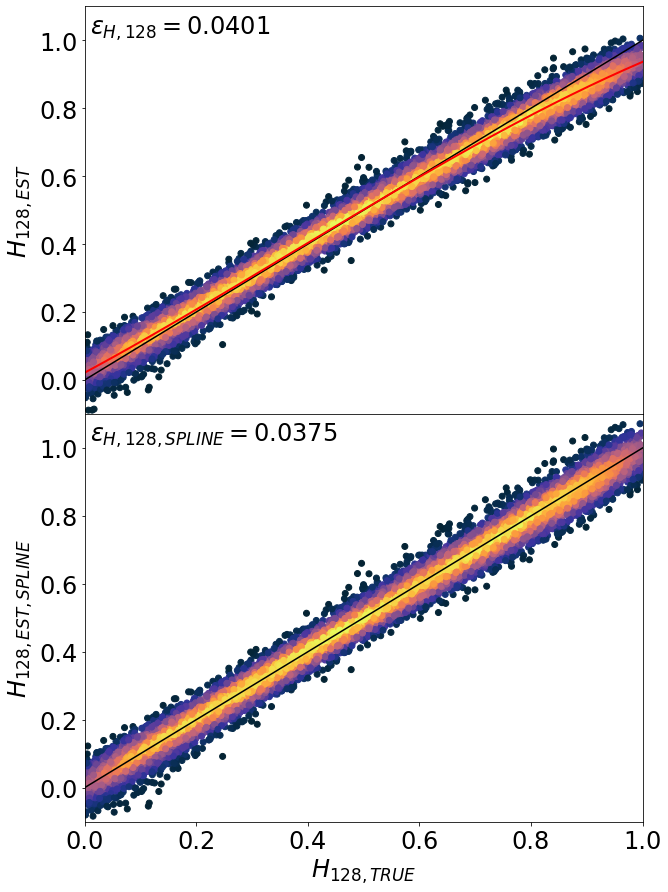

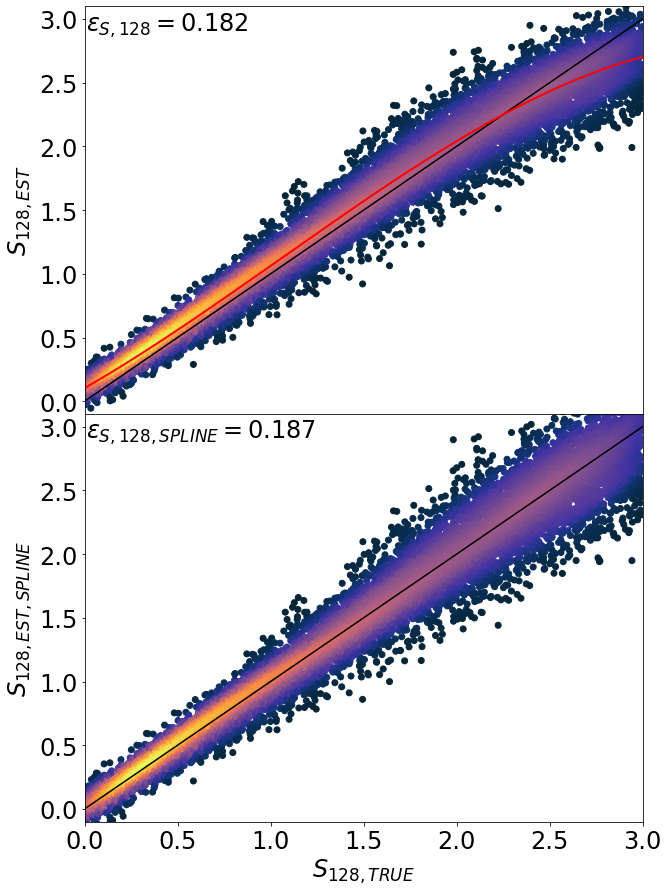

In [9]:
val_loss = root_mean_square_error(df_128['H_actual'],df_128['H_pred'])
xs_H = np.linspace(0,1,1000)
plt.rcParams.update({'font.size': 24})

f, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10*1.5))
ax1.scatter(df_128['H_actual'],df_128['H_pred'],c=df_128['color_H'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 1.02, fr'$\epsilon_{{H,128}} = {val_loss:.3}$')
ax1.plot([0,1],[0,1],c='k')
ax1.plot(xs_H, spl_H_128(xs_H), 'r', lw=2)
ax1.set_ylabel(r'$H_{128,EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,1])
ax1.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df_128['H_actual'],df_128['H_pred_splined'])
ax2.scatter(df_128['H_actual'],df_128['H_pred_splined'],c=df_128['color_H'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 1.02, fr'$\epsilon_{{H,128,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,1],[0,1],c='k')
ax2.set_xlabel(r'$H_{128,TRUE}$')
ax2.set_ylabel(r'$H_{128,EST,SPLINE}$')
ax2.set_xlim([0,1])
ax2.set_ylim([-0.1,1.1])
f.subplots_adjust(wspace=0, hspace=0)

plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/128pxCNN_Hplot_CENTRED.png', bbox_inches='tight')
plt.show()

###############

val_loss = root_mean_square_error(df_128['S_actual'],df_128['S_pred'])
xs_S = np.linspace(0,3,1000)

f, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10*1.5))
ax1.scatter(df_128['S_actual'],df_128['S_pred'],c=df_128['color_S'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 2.91, fr'$\epsilon_{{S,128}} = {val_loss:.3}$')
ax1.plot([0,3],[0,3],c='k')
ax1.plot(xs_S, spl_S_128(xs_S), 'r', lw=2)
ax1.set_ylabel(r'$S_{128,EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,3])
ax1.set_ylim([-0.1,3.1])

val_loss = root_mean_square_error(df_128['S_actual'],df_128['S_pred_splined'])
ax2.scatter(df_128['S_actual'],df_128['S_pred_splined'],c=df_128['color_S'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 2.91, fr'$\epsilon_{{S,128,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,3],[0,3],c='k')
ax2.set_xlabel(r'$S_{128,TRUE}$')
ax2.set_ylabel(r'$S_{128,EST,SPLINE}$')
ax2.set_xlim([0,3])
ax2.set_ylim([-0.1,3.1])
f.subplots_adjust(wspace=0, hspace=0)

plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/128pxCNN_Splot_CENTRED.png', bbox_inches='tight')
plt.show()

## 64px model

In [10]:
# model_64px = tf.keras.models.load_model('D:/Workshop/PhD/Models/CNN for fbm Fields/64pxmodel')
model_64px = tf.keras.models.load_model('D:/Workshop/PhD/Models/model64px_large.h5')
model_64px.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0     

In [11]:
E=2
N_p=64

In [12]:
preds=[]
Y=[]
N_fields = 10000
for i in tqdm(range(N_fields)):
    pred,y = gen(model_64px, N_p, E)
    preds.append(pred[0])
    Y.append(y)
    
print(Y[0],preds[0])    

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]D:\Workshop\PhD\Scripts\SpectralSynthesis.py:58: RuntimeWarning: divide by zero encountered in power
  rad = np.where(k>0.0,k**(-(beta*0.5)),0.0)
D:\Workshop\PhD\Scripts\SpectralSynthesis.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phaseneg = phase[[slice(None,None,-1)]*E]
D:\Workshop\PhD\Scripts\SpectralSynthesis.py:72: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  A[i_minus] += A[i_plus]
D:\Workshop\PhD\Scripts

[0.87272917 1.49438685] [0.819407  1.4643645]


In [13]:
H_pred = [pred[0] for pred in preds]
S_pred = [pred[1] for pred in preds]
H_actual = [y[0] for y in Y]
S_actual = [y[1] for y in Y]
print(H_pred[:4],H_actual[:4])

[0.819407, 0.654524, 0.4787686, 0.5125658] [0.8727291702119223, 0.6829688491010947, 0.4889221001310893, 0.5444318121365491]


In [14]:
df = pd.DataFrame()

df['H_actual'] = H_actual
df['H_pred'] = H_pred
df['S_actual'] = S_actual
df['S_pred'] = S_pred

df = df.sort_values(by=['H_actual'])
xy = np.vstack([df['H_actual'],df['H_pred']])
z = gaussian_kde(xy)(xy)
spl_H = UnivariateSpline(df['H_actual'].to_list(),df['H_pred'].to_list())
df['color_H'] = z

df = df.sort_values(by=['S_actual'])
xy = np.vstack([df['S_actual'],df['S_pred']])
z = gaussian_kde(xy)(xy)
spl_S = UnivariateSpline(df['S_actual'].to_list(),df['S_pred'].to_list())
df['color_S'] = z

df['H_pred_splined'] = 2*np.array(df['H_pred'])- np.array(spl_H(df['H_pred']))
df['S_pred_splined'] = 2*np.array(df['S_pred'])- np.array(spl_S(df['S_pred']))

df

H_actual    H_pred  S_actual    S_pred   color_H   color_S  \
4347  0.274618  0.128467  0.000575  0.159277  0.891979  0.530153   
5185  0.833540  0.883272  0.000599  0.134445  4.466098  0.671191   
541   0.158003  0.168104  0.001014  0.082303  4.282205  0.811738   
6153  0.192116  0.202805  0.001401  0.052197  4.028698  0.743147   
7482  0.567688  0.676020  0.001859  0.144187  0.462191  0.627758   
...        ...       ...       ...       ...       ...       ...   
3563  0.535256  0.499222  2.998664  2.836598  7.664817  0.274565   
6320  0.769690  0.783164  2.999200  3.154376  6.820808  0.035429   
1911  0.927991  0.876831  2.999283  2.579182  4.474744  0.252227   
9627  0.619193  0.545966  2.999372  2.268028  4.752012  0.050891   
7212  0.830106  0.803797  2.999890  2.848452  6.712399  0.261839   

      H_pred_splined  S_pred_splined  
4347        0.167213        0.088784  
5185        0.887581        0.061496  
541         0.211461        0.003519  
6153        0.248669       -0.030391  
7482        0.684466        0.072225  
...              ...             ...  
3563        0.527925        3.109415  
6320        0.785190        3.666185  
1911        0.880687        2.712667  
9627        0.568919        2.287679  
7212        0.805526        3.128792  

[10000 rows x 8 columns]

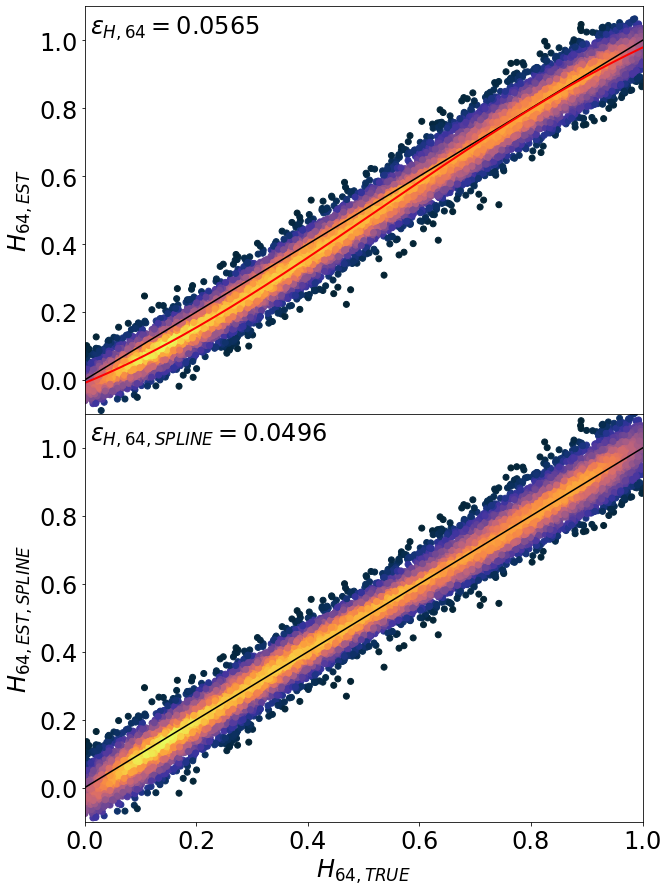

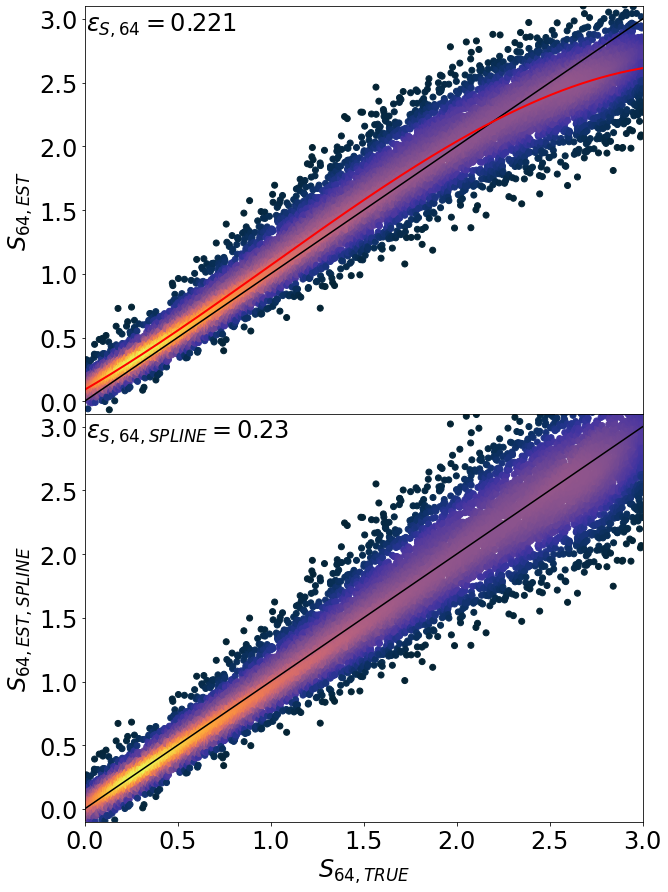

In [15]:
val_loss = root_mean_square_error(df['H_actual'],df['H_pred'])
xs_H = np.linspace(0,1,1000)
plt.rcParams.update({'font.size': 24})

f, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10*1.5))
ax1.scatter(df['H_actual'],df['H_pred'],c=df['color_H'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 1.02, fr'$\epsilon_{{H,64}} = {val_loss:.3}$')
ax1.plot([0,1],[0,1],c='k')
ax1.plot(xs_H, spl_H(xs_H), 'r', lw=2)
ax1.set_ylabel(r'$H_{64,EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,1])
ax1.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df['H_actual'],df['H_pred_splined'])
ax2.scatter(df['H_actual'],df['H_pred_splined'],c=df['color_H'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 1.02, fr'$\epsilon_{{H,64,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,1],[0,1],c='k')
ax2.set_xlabel(r'$H_{64,TRUE}$')
ax2.set_ylabel(r'$H_{64,EST,SPLINE}$')
ax2.set_xlim([0,1])
ax2.set_ylim([-0.1,1.1])
f.subplots_adjust(wspace=0, hspace=0)

plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/64pxCNN_Hplot_CENTRED_rejigged.png', bbox_inches='tight')
plt.show()

###############

val_loss = root_mean_square_error(df['S_actual'],df['S_pred'])
xs_S = np.linspace(0,3,1000)

f, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10*1.5))
ax1.scatter(df['S_actual'],df['S_pred'],c=df['color_S'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 2.91, fr'$\epsilon_{{S,64}} = {val_loss:.3}$')
ax1.plot([0,3],[0,3],c='k')
ax1.plot(xs_S, spl_S(xs_S), 'r', lw=2)
ax1.set_ylabel(r'$S_{64,EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,3])
ax1.set_ylim([-0.1,3.1])

val_loss = root_mean_square_error(df['S_actual'],df['S_pred_splined'])
ax2.scatter(df['S_actual'],df['S_pred_splined'],c=df['color_S'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 2.91, fr'$\epsilon_{{S,64,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,3],[0,3],c='k')
ax2.set_xlabel(r'$S_{64,TRUE}$')
ax2.set_ylabel(r'$S_{64,EST,SPLINE}$')
ax2.set_xlim([0,3])
ax2.set_ylim([-0.1,3.1])
f.subplots_adjust(wspace=0, hspace=0)

plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/64pxCNN_Splot_CENTRED_rejigged.png', bbox_inches='tight')
plt.show()

## 32px model

In [16]:
model_32px = tf.keras.models.load_model('D:/Workshop/PhD/Models/CNN for fbm Fields/32pxmodel')
model_32px.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0     

In [17]:
E=2
N_p=32

In [18]:
preds=[]
Y=[]
N_fields = 10000
for i in tqdm(range(N_fields)):
    pred,y = gen(model_32px, N_p, E)
    preds.append(pred[0])
    Y.append(y)
    
print(Y[0],preds[0])    

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]D:\Workshop\PhD\Scripts\SpectralSynthesis.py:58: RuntimeWarning: divide by zero encountered in power
  rad = np.where(k>0.0,k**(-(beta*0.5)),0.0)
D:\Workshop\PhD\Scripts\SpectralSynthesis.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phaseneg = phase[[slice(None,None,-1)]*E]
D:\Workshop\PhD\Scripts\SpectralSynthesis.py:72: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  A[i_minus] += A[i_plus]
D:\Workshop\PhD\Scripts

[0.99222066 2.83188049] [0.9169088 2.2455502]


In [19]:
H_pred = [pred[0] for pred in preds]
S_pred = [pred[1] for pred in preds]
H_actual = [y[0] for y in Y]
S_actual = [y[1] for y in Y]
print(H_pred[:4],H_actual[:4])

[0.9169088, 0.20920888, 0.32105777, 0.9052123] [0.9922206602371255, 0.3440410761828484, 0.3596492165180373, 0.8327938543490558]


In [20]:
df_32 = pd.DataFrame()

df_32['H_actual'] = H_actual
df_32['H_pred'] = H_pred
df_32['S_actual'] = S_actual
df_32['S_pred'] = S_pred

df_32 = df_32.sort_values(by=['H_actual'])
xy = np.vstack([df_32['H_actual'],df_32['H_pred']])
z = gaussian_kde(xy)(xy)
spl_H_32 = UnivariateSpline(df_32['H_actual'].to_list(),df_32['H_pred'].to_list())
df_32['color_H'] = z

df_32 = df_32.sort_values(by=['S_actual'])
xy = np.vstack([df_32['S_actual'],df_32['S_pred']])
z = gaussian_kde(xy)(xy)
spl_S_32 = UnivariateSpline(df_32['S_actual'].to_list(),df_32['S_pred'].to_list())
df_32['color_S'] = z

df_32

H_actual    H_pred  S_actual    S_pred   color_H   color_S
7834  0.260935  0.414980  0.000156  0.165214  1.569434  0.640483
6883  0.540987  0.774268  0.000520  0.210672  0.479906  0.645149
9123  0.620189  0.892584  0.001139  0.102442  0.161910  0.418499
2569  0.855016  1.014863  0.001454  0.282940  0.938978  0.393389
297   0.264167  0.511194  0.001501  0.179290  0.260866  0.662215
...        ...       ...       ...       ...       ...       ...
1976  0.342899  0.186092  2.998448  2.220812  0.957123  0.071272
7875  0.088136 -0.010291  2.998473  2.749834  1.835307  0.256272
7742  0.753255  0.604767  2.998726  2.461609  0.780418  0.223331
3754  0.865205  0.784500  2.998827  2.689636  3.268378  0.290004
3370  0.165741  0.042878  2.999100  2.539833  1.565094  0.271128

[10000 rows x 6 columns]

In [21]:
df_32['H_pred_splined'] = 2*np.array(df_32['H_pred'])- np.array(spl_H_32(df_32['H_pred']))
df_32['S_pred_splined'] = 2*np.array(df_32['S_pred'])- np.array(spl_S_32(df_32['S_pred']))
df_32

H_actual    H_pred  S_actual    S_pred   color_H   color_S  \
7834  0.260935  0.414980  0.000156  0.165214  1.569434  0.640483   
6883  0.540987  0.774268  0.000520  0.210672  0.479906  0.645149   
9123  0.620189  0.892584  0.001139  0.102442  0.161910  0.418499   
2569  0.855016  1.014863  0.001454  0.282940  0.938978  0.393389   
297   0.264167  0.511194  0.001501  0.179290  0.260866  0.662215   
...        ...       ...       ...       ...       ...       ...   
1976  0.342899  0.186092  2.998448  2.220812  0.957123  0.071272   
7875  0.088136 -0.010291  2.998473  2.749834  1.835307  0.256272   
7742  0.753255  0.604767  2.998726  2.461609  0.780418  0.223331   
3754  0.865205  0.784500  2.998827  2.689636  3.268378  0.290004   
3370  0.165741  0.042878  2.999100  2.539833  1.565094  0.271128   

      H_pred_splined  S_pred_splined  
7834        0.399300        0.010358  
6883        0.757856        0.063062  
9123        0.894022       -0.063541  
2569        1.052778        0.145549  
297         0.491926        0.026747  
...              ...             ...  
1976        0.167566        2.288195  
7875       -0.065286        3.067704  
7742        0.582920        2.622721  
3754        0.769078        2.970330  
3370        0.002242        2.738344  

[10000 rows x 8 columns]

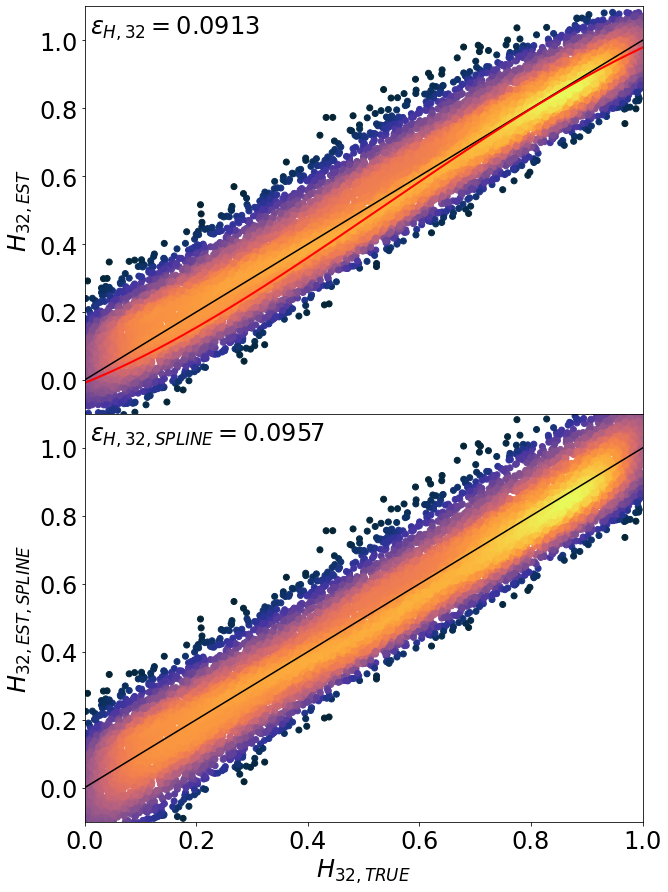

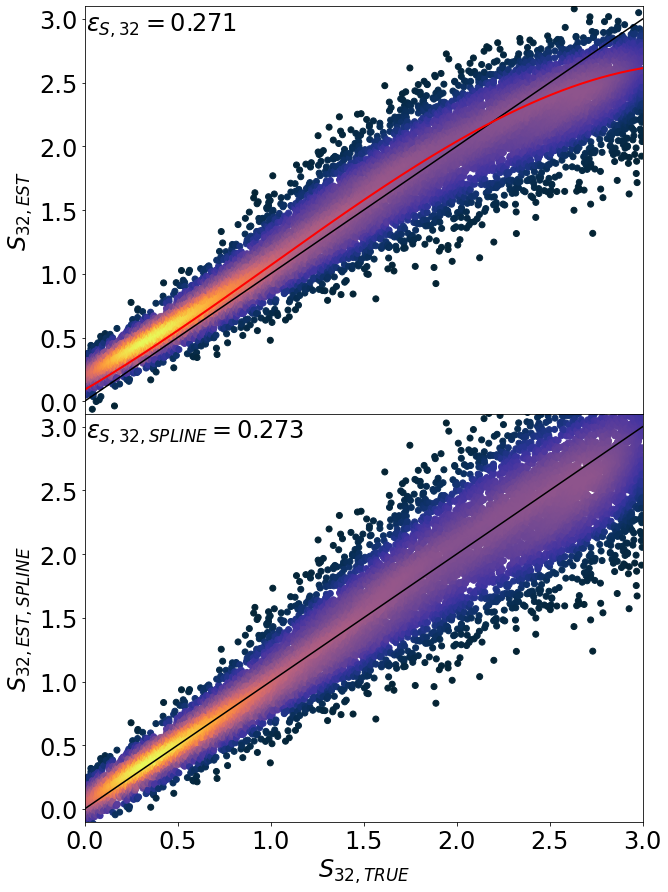

In [22]:
val_loss = root_mean_square_error(df_32['H_actual'],df_32['H_pred'])
xs_H = np.linspace(0,1,1000)

f, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10*1.5))
ax1.scatter(df_32['H_actual'],df_32['H_pred'],c=df_32['color_H'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 1.02, fr'$\epsilon_{{H,32}} = {val_loss:.3}$')
ax1.plot([0,1],[0,1],c='k')
ax1.plot(xs_H, spl_H(xs_H), 'r', lw=2)
ax1.set_ylabel(r'$H_{32,EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,1])
ax1.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df_32['H_actual'],df_32['H_pred_splined'])
ax2.scatter(df_32['H_actual'],df_32['H_pred_splined'],c=df_32['color_H'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 1.02, fr'$\epsilon_{{H,32,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,1],[0,1],c='k')
ax2.set_xlabel(r'$H_{32,TRUE}$')
ax2.set_ylabel(r'$H_{32,EST,SPLINE}$')
ax2.set_xlim([0,1])
ax2.set_ylim([-0.1,1.1])
f.subplots_adjust(wspace=0, hspace=0)

plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/32pxCNN_Hplot_CENTRED.png', bbox_inches='tight')
plt.show()

###############

val_loss = root_mean_square_error(df_32['S_actual'],df_32['S_pred'])
xs_S = np.linspace(0,3,1000)

f, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10*1.5))
ax1.scatter(df_32['S_actual'],df_32['S_pred'],c=df_32['color_S'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 2.91, fr'$\epsilon_{{S,32}} = {val_loss:.3}$')
ax1.plot([0,3],[0,3],c='k')
ax1.plot(xs_S, spl_S(xs_S), 'r', lw=2)
ax1.set_ylabel(r'$S_{32,EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,3])
ax1.set_ylim([-0.1,3.1])

val_loss = root_mean_square_error(df_32['S_actual'],df_32['S_pred_splined'])
ax2.scatter(df_32['S_actual'],df_32['S_pred_splined'],c=df_32['color_S'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 2.91, fr'$\epsilon_{{S,32,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,3],[0,3],c='k')
ax2.set_xlabel(r'$S_{32,TRUE}$')
ax2.set_ylabel(r'$S_{32,EST,SPLINE}$')
ax2.set_xlim([0,3])
ax2.set_ylim([-0.1,3.1])
f.subplots_adjust(wspace=0, hspace=0)

plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/32pxCNN_Splot_CENTRED.png', bbox_inches='tight')
plt.show()

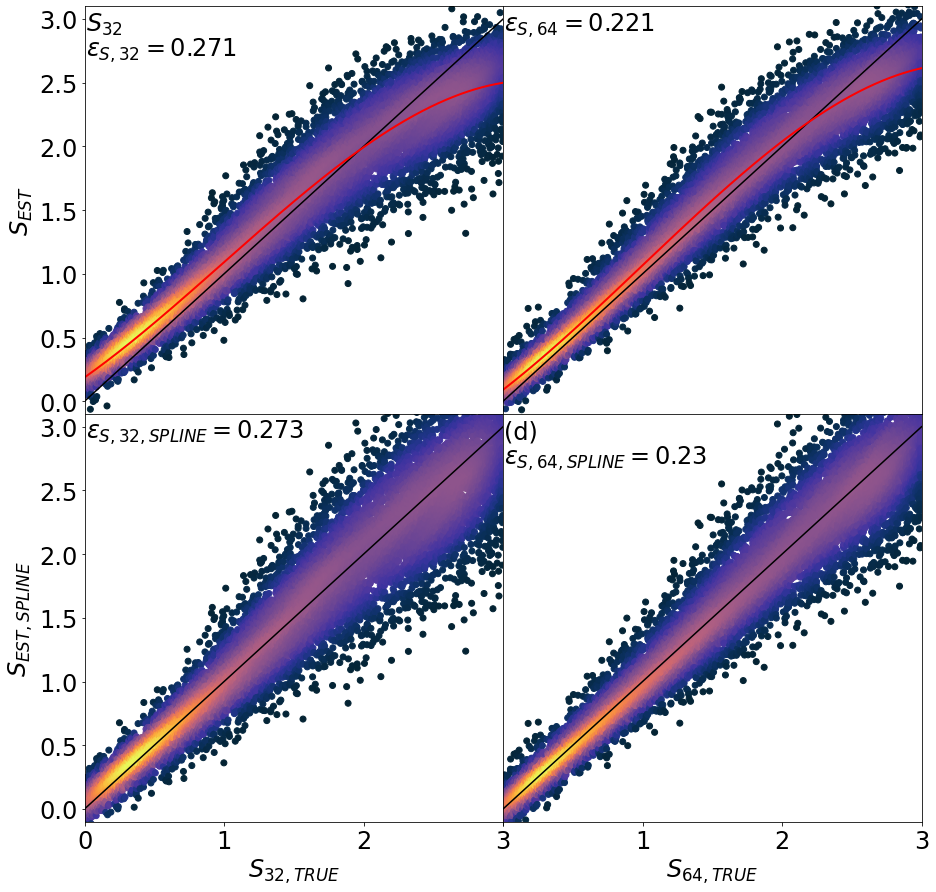

In [23]:
plt.rcParams.update({'font.size': 24})
xs_S = np.linspace(0,3,1000)

f, ((ax1,ax3), (ax2,ax4)) = plt.subplots(2,2, figsize=(15, 10*1.5))

val_loss = root_mean_square_error(df_32['S_actual'],df_32['S_pred'])
ax1.scatter(df_32['S_actual'],df_32['S_pred'],c=df_32['color_S'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 2.91, fr'$S_{{32}}$')
ax1.text(0.01, 2.71, fr'$\epsilon_{{S,32}} = {val_loss:.3}$')
ax1.plot([0,3],[0,3],c='k')
ax1.plot(xs_S, spl_S_32(xs_S), 'r', lw=2)
ax1.set_ylabel(r'$S_{EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,3])
ax1.set_ylim([-0.1,3.1])

val_loss = root_mean_square_error(df_32['S_actual'],df_32['S_pred_splined'])
ax2.scatter(df_32['S_actual'],df_32['S_pred_splined'],c=df_32['color_S'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 2.91, fr'$\epsilon_{{S,32,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,3],[0,3],c='k')
ax2.set_xlabel(r'$S_{32,TRUE}$')
ax2.set_ylabel(r'$S_{EST,SPLINE}$')
ax2.set_xlim([0,3])
ax2.set_ylim([-0.1,3.1])

val_loss = root_mean_square_error(df['S_actual'],df['S_pred'])
ax3.scatter(df['S_actual'],df['S_pred'],c=df['color_S'],cmap=cmocean.cm.thermal)
ax3.text(0.01, 2.91, fr'$\epsilon_{{S,64}} = {val_loss:.3}$')
ax3.plot([0,3],[0,3],c='k')
ax3.plot(xs_S, spl_S(xs_S), 'r', lw=2)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlim([0,3])
ax3.set_ylim([-0.1,3.1])

val_loss = root_mean_square_error(df['S_actual'],df['S_pred_splined'])
ax4.scatter(df['S_actual'],df['S_pred_splined'],c=df['color_S'],cmap=cmocean.cm.thermal)
ax4.text(0.01, 2.91, '(d)')
ax4.text(0.01, 2.71, fr'$\epsilon_{{S,64,SPLINE}} = {val_loss:.3}$')
ax4.plot([0,3],[0,3],c='k')
ax4.set_xlabel(r'$S_{64,TRUE}$')
ax4.set_yticks([])
ax4.set_xlim([0,3])
ax4.set_ylim([-0.1,3.1])

x_ticks = ax4.xaxis.get_major_ticks()
x_ticks[0].label1.set_visible(False)
f.subplots_adjust(wspace=0, hspace=0)
plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/32pxCNN_Splot_CENTRED_mod_rejigged.png', bbox_inches='tight')
plt.show()

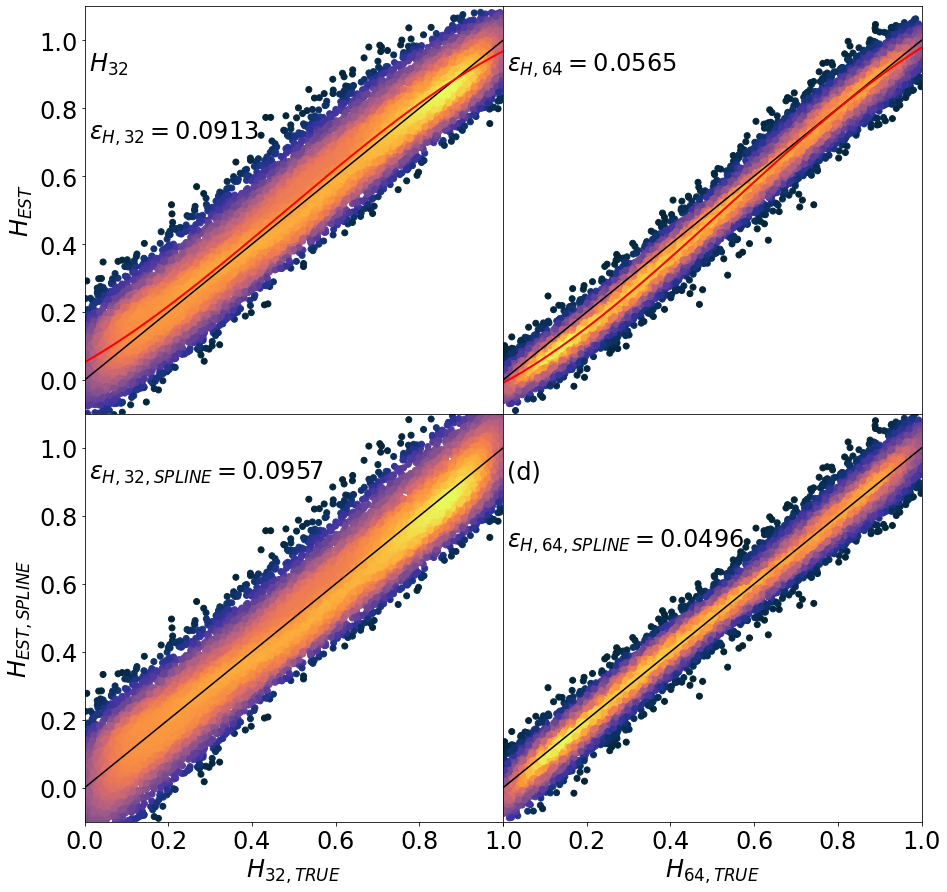

In [24]:
xs_H = np.linspace(0,1,1000)

f, ((ax1,ax3), (ax2,ax4)) = plt.subplots(2,2, figsize=(15, 10*1.5))

val_loss = root_mean_square_error(df_32['H_actual'],df_32['H_pred'])
ax1.scatter(df_32['H_actual'],df_32['H_pred'],c=df_32['color_H'],cmap=cmocean.cm.thermal)
ax1.text(0.01, 0.91, fr'$H_{{32}}$')
ax1.text(0.01, 0.71, fr'$\epsilon_{{H,32}} = {val_loss:.3}$')
ax1.plot([0,1],[0,1],c='k')
ax1.plot(xs_H, spl_H_32(xs_H), 'r', lw=2)
ax1.set_ylabel(r'$H_{EST}$')
ax1.set_xticks([])
ax1.set_xlim([0,1])
ax1.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df_32['H_actual'],df_32['H_pred_splined'])
ax2.scatter(df_32['H_actual'],df_32['H_pred_splined'],c=df_32['color_H'],cmap=cmocean.cm.thermal)
ax2.text(0.01, 0.91, fr'$\epsilon_{{H,32,SPLINE}} = {val_loss:.3}$')
ax2.plot([0,1],[0,1],c='k')
ax2.set_xlabel(r'$H_{32,TRUE}$')
ax2.set_ylabel(r'$H_{EST,SPLINE}$')
ax2.set_xlim([0,1])
ax2.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df['H_actual'],df['H_pred'])
ax3.scatter(df['H_actual'],df['H_pred'],c=df['color_H'],cmap=cmocean.cm.thermal)
ax3.text(0.01, 0.91, fr'$\epsilon_{{H,64}} = {val_loss:.3}$')
ax3.plot([0,1],[0,1],c='k')
ax3.plot(xs_H, spl_H(xs_H), 'r', lw=2)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlim([0,1])
ax3.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df['H_actual'],df['H_pred_splined'])
ax4.scatter(df['H_actual'],df['H_pred_splined'],c=df['color_H'],cmap=cmocean.cm.thermal)
ax4.text(0.01, 0.91, '(d)')
ax4.text(0.01, 0.71, fr'$\epsilon_{{H,64,SPLINE}} = {val_loss:.3}$')
ax4.plot([0,1],[0,1],c='k')
ax4.set_xlabel(r'$H_{64,TRUE}$')
ax4.set_yticks([])
ax4.set_xlim([0,1])
ax4.set_ylim([-0.1,1.1])

x_ticks = ax4.xaxis.get_major_ticks()
x_ticks[0].label1.set_visible(False)
f.subplots_adjust(wspace=0, hspace=0)
plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/32pxCNN_Hplot_CENTRED_mod_rejigged.png', bbox_inches='tight')
plt.show()

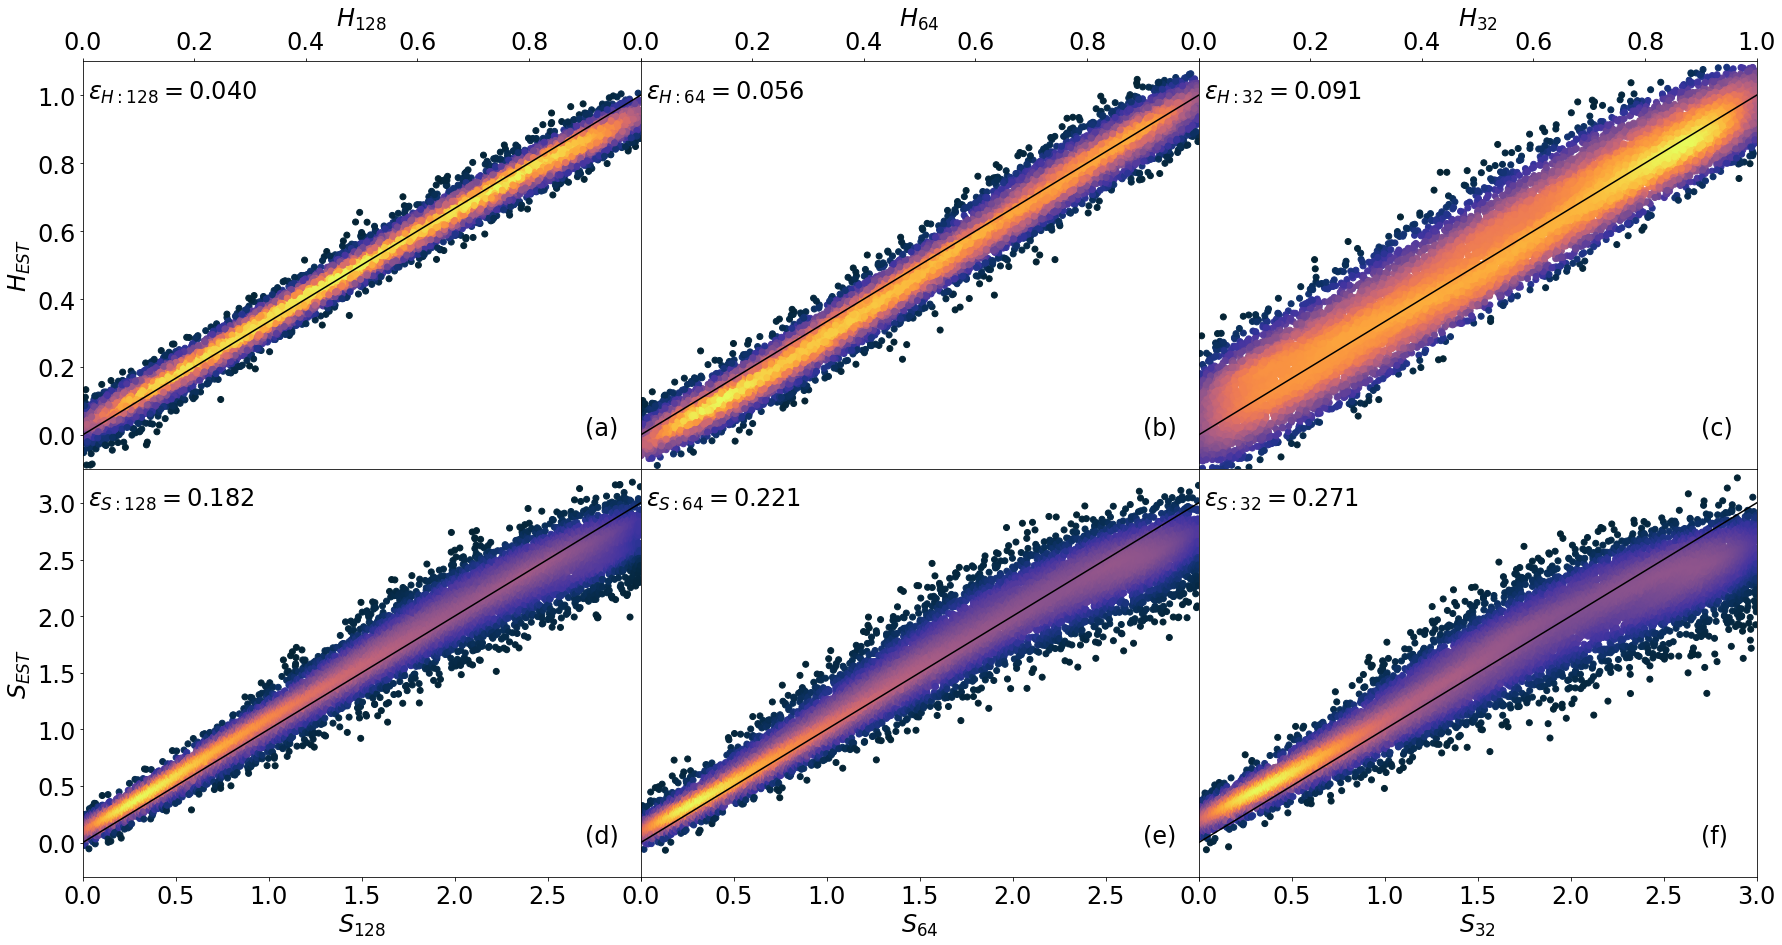

In [31]:
xs_H = np.linspace(0,1,1000)

f, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(30, 10*1.5))

val_loss = root_mean_square_error(df_128['H_actual'],df_128['H_pred'])
ax1.scatter(df_128['H_actual'],df_128['H_pred'],c=df_128['color_H'],cmap=cmocean.cm.thermal)
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.text(0.01, 0.99, fr'$\epsilon_{{H:128}} = {val_loss:.3f}$')
ax1.text(0.9, 0, '(a)')
ax1.plot([0,1],[0,1],c='k')
ax1.set_ylabel(r'$H_{EST}$')
ax1.set_xlabel(r'$H_{128}$')
ax1.set_xlim([0,1])
ax1.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df['H_actual'],df['H_pred'])
ax2.scatter(df['H_actual'],df['H_pred'],c=df['color_H'],cmap=cmocean.cm.thermal)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 
ax2.set_xlabel(r'$H_{64}$')
ax2.text(0.01, 0.99, fr'$\epsilon_{{H:64}} = {val_loss:.3f}$')
ax2.text(0.9, 0, '(b)')
ax2.plot([0,1],[0,1],c='k')
ax2.set_yticks([])
ax2.set_xlim([0,1])
ax2.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df_32['H_actual'],df_32['H_pred'])
ax3.scatter(df_32['H_actual'],df_32['H_pred'],c=df_32['color_H'],cmap=cmocean.cm.thermal)
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')
ax3.set_xlabel(r'$H_{32}$')
ax3.text(0.01, 0.99, fr'$\epsilon_{{H:32}} = {val_loss:.3f}$')
ax3.plot([0,1],[0,1],c='k')
ax3.set_yticks([])
ax3.text(0.9, 0, '(c)')
ax3.set_xlim([0,1])
ax3.set_ylim([-0.1,1.1])

val_loss = root_mean_square_error(df_128['S_actual'],df_128['S_pred'])
ax4.scatter(df_128['S_actual'],df_128['S_pred'],c=df_128['color_S'],cmap=cmocean.cm.thermal)
ax4.text(0.01*3, 0.99*3, fr'$\epsilon_{{S:128}} = {val_loss:.3f}$')
ax4.text(0.9*3, 0, '(d)')
ax4.plot([0,3],[0,3],c='k')
ax4.set_ylabel(r'$S_{EST}$')
ax4.set_xlabel(r'$S_{128}$')
ax4.set_xlim([0,3])
ax4.set_ylim([-0.1*3,1.1*3])

val_loss = root_mean_square_error(df['S_actual'],df['S_pred'])
ax5.scatter(df['S_actual'],df['S_pred'],c=df['color_S'],cmap=cmocean.cm.thermal)
ax5.text(0.01*3, 0.99*3, fr'$\epsilon_{{S:64}} = {val_loss:.3f}$')
ax5.text(0.9*3, 0, '(e)')
ax5.plot([0,3],[0,3],c='k')
ax5.set_xlabel(r'$S_{64}$')
ax5.set_xlim([0,3])
ax5.set_yticks([])
ax5.set_ylim([-0.1*3,1.1*3])

val_loss = root_mean_square_error(df_32['S_actual'],df_32['S_pred'])
ax6.scatter(df_32['S_actual'],df_32['S_pred'],c=df_32['color_S'],cmap=cmocean.cm.thermal)
ax6.text(0.01*3, 0.99*3, fr'$\epsilon_{{S:32}} = {val_loss:.3f}$')
ax6.text(0.9*3, 0, '(f)')
ax6.plot([0,3],[0,3],c='k')
ax6.set_xlabel(r'$S_{32}$')
ax6.set_xlim([0,3])
ax6.set_yticks([])
ax6.set_ylim([-0.1*3,1.1*3])

ax1_x_ticks = ax1.xaxis.get_major_ticks()
ax1_x_ticks[-1].label2.set_visible(False)
ax2_x_ticks = ax2.xaxis.get_major_ticks()
ax2_x_ticks[-1].label2.set_visible(False)

ax4_x_ticks = ax4.xaxis.get_major_ticks()
ax4_x_ticks[-1].label1.set_visible(False)
ax5_x_ticks = ax5.xaxis.get_major_ticks()
ax5_x_ticks[-1].label1.set_visible(False)

f.subplots_adjust(wspace=0, hspace=0)
plt.savefig('D:/Workshop/PhD/Papers/HiGal paper/Images/CNN_combined_performance.png', bbox_inches='tight')
plt.show()